Идея
Как распознать фейк? - со 100 вероятностью это возможно только после прочтения всей новостной статьи и подкреплением информации из других источников. поэтому считаю что тут задача стоит несколько иная.

На просторах интернет океан информации и многие хотят создать привлекающий внимание заголовок для получения посещаемости именно своего источника - Кликбейт(использование «кричащих» заголовков). Для создания такого используется несколько другой стиль написания текста - соответсвенно считаю что необходимо сделать упор например на состав частей речи, морфологию и синтаксис.


# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика F1 score.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.tsv` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.tsv` должен включать в себя колонку title, содержащую те же данные, что и исходный файл `test.tsv`, а также колонку is_fake, содержащую значения 0 или 1.
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, 
необходимый для воспроизведения исследования.

Успехов!

## Оглавление:
* [1. Загрузка и обзор данных](#loading_data)

* [2. Предварительная обработка текста](#pre_text)

* [3. Создание новых признаков](#feature_eng)

* [4. Разделение на train/valid выборки](#train_valid)

* [5. Векторизация](#vector)

* [6. Оптимальная модель и кросс валидация](#cross_val)
* [6.1 Случайный лес](#random_forest)

* [6.2 Оценка важности признаков](#feature_importances)
* [6.3 Логистическая регрессия](#log_reg)

* [7. Финал](#final)
* [7.1 Подготовка тестового датасета](#test_data)
* [7.2 Тестирование](#test)

Для исследования воспользуюсь полученными знаниями с курса который прохожу в данны момент. 

Кроме тривиальных признаков как количество слов, добуду инфу о количестве частей речи и используемых падежах. А также одним из видов модели "мешок слов".

## 1. Загрузка и обзор данных  <a class="anchor" id="loading_data"></a>


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


# импортируем сразу все требуемые модули
import pandas as pd
import numpy as np
#import re
import string
 
# загрузим морфологический анализатор для русского языка
# на случай если не установлен пакет
!pip install pymorphy2
import pymorphy2

# на случай если не установлен пакет
#!pip install nltk
import nltk
# подгрузим лексическую  базы данных
nltk.download('wordnet')
# и базу "ненужных" слов
nltk.download('stopwords')
# для удаления некоторых слов
from nltk.corpus import stopwords
# для лемматизации текста
from nltk.stem import WordNetLemmatizer

# импортируем библиотеки для из sklearn
from sklearn.model_selection import train_test_split    # для ращделения на train/valid выборки
from sklearn.model_selection import GridSearchCV        # для перебора гиперпараметров модели и выбора лучших
from sklearn.feature_extraction.text import TfidfVectorizer # для векторизации текста для создания признаков
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karlashov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karlashov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# использую конструкцию try-except на случай если не получится работать над проектам локально
try:
    train_df = pd.read_csv('dataset/train.tsv', sep='\t') 
    test_df =  pd.read_csv('dataset/test.tsv', sep='\t')
except:
    # для работы в Colab и загрузкой с google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    train_df = pd.read_csv('/content/gdrive/My Drive/DS/datasets/nlp_test_task/train.tsv', sep='\t')
    test_df =  pd.read_csv('/content/gdrive/My Drive/DS/datasets/nlp_test_task/test.tsv', sep='\t')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [4]:
train_df['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Данные загрузились нормально. Они чисты от пропусков и баланс классов идеальный.

## 2. Предварительная обработка текста  <a class="anchor" id="pre_text"></a> 

Текст может содержать цифры, специальные символы и ненужные пробелы. В зависимости от проблемы, с которой мы сталкиваемся, нам может понадобиться или не понадобиться удалять эти специальные символы и цифры из текста.

In [5]:
# инициализируем экземпляр класса  MorphAnalyzer 
# принимает слово и возвращает все возможные разборы
morph = pymorphy2.MorphAnalyzer()

np.random.seed(42)

# объединим в функцию все нужные манипуляции для очистки текста

def text_cleaning(text):
    # удаление всех не буквенных символов:
    text = ''.join([char for char in text if char.isalpha() or char==' '])

    # преобразуем в нижний регистр
    text = text.lower()
    
    # лемматизация  - для преобразования слов в базовую форму
    text = text.split()
    txt = []
    for word in text:
        m = morph.parse(word)[0]  
        txt.append(m.normal_form)  # отбираем из вывода всевозможных форм только нормальную 
    text = ' '.join(txt)
    return text


In [6]:
# применим "очиститель" и сохраним в отдельный столбец
train_df['clean_text'] = train_df['title'].apply(lambda x: text_cleaning(x))
train_df.head()

,title,is_fake,clean_text
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутина прийти счёт за вмешат...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин назвать езда по встречка житейск...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассмотреть возможность введение секре...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный завести дело о недоносительст...


## 3. Создание новых признаков   <a class="anchor" id="feature_eng"></a> 

создадим признаки которые могут благотворно сказаться на обучении модели

In [7]:
# функция для вычисления доли символов пунктуации
def pcnt_punct(text):
    A = text.split()
    count = sum([1 for char in text if char in string.punctuation])
    return int(round( count / (len(text) - text.count(' ')), 3) * 1000)


# доля знаков пунктуации в title
train_df['pcnt_punct'] = train_df['title'].apply(lambda x: pcnt_punct(x))

In [8]:

#  колонка с количеством символов в title   
#train_df['len_text'] = train_df['title'].apply(lambda x: len(x))

# train_df['len_text'] = train_df['title'].apply(lambda x: sum([len(y) for y in x.split()]))

# количество слов в title
train_df['count_words'] = train_df['title'].apply(lambda x: sum([1 for y in x.split()]))

# количество заглавных букв 
train_df['sum_upper_chars'] = train_df['title'].apply(lambda x: sum([1 for y in x if y.isupper()]))

In [9]:
POS_list =['NOUN','ADJF','ADJS','COMP','VERB','INFN','PRTF','PRTS','GRND','NUMR','ADVB','NPRO','PRED','PREP','CONJ','PRCL','INTJ']
case_list = ['nomn','gent','datv','accs','ablt','loct','voct','gen2','acc2','loc2']
POS_case_list =  POS_list + case_list
 
def get_pos_case_count(text, pos_case):
    count = 0
    for word in text.split():
        p = morph.parse(word)[0]
        if pos_case in POS_list:
            t = str(p.tag.POS)
        else:    
            t = str(p.tag.case) 
        if t == pos_case:
            count += 1
    return count

# создание признаков на каждую часть речи и падеж - перечень обозначений из библиотеки  pymorphy2
for pc in POS_case_list:
    if pc in POS_list:
        col_name = 'pos_' + pc
    else:
        col_name = 'case_' + pc
    train_df[col_name] = train_df['title'].apply(lambda x: get_pos_case_count(x,pc))

In [10]:
# предварительно обратим внимание на корреляцию признаков с признаком is_fake
train_df.corr().head(5)

,is_fake,pcnt_punct,count_words,sum_upper_chars,pos_NOUN,pos_ADJF,pos_ADJS,pos_COMP,pos_VERB,pos_INFN,...,case_nomn,case_gent,case_datv,case_accs,case_ablt,case_loct,case_voct,case_gen2,case_acc2,case_loc2
is_fake,1.000000,0.202012,0.487473,0.142369,0.321121,0.204011,0.015644,0.036717,0.100223,0.195180,...,0.081740,0.260839,0.089358,0.103557,0.082937,0.132224,0.018640,NaN,NaN,0.032598
pcnt_punct,0.202012,1.000000,0.193135,0.168080,-0.069349,0.006742,0.023388,0.021311,0.075969,0.004694,...,0.044267,-0.032144,-0.010929,-0.023332,0.018860,-0.025984,0.001810,NaN,NaN,0.001320
count_words,0.487473,0.193135,1.000000,0.292837,0.663536,0.345466,0.060382,0.057720,0.210827,0.163623,...,0.242329,0.464283,0.123203,0.182157,0.103168,0.288412,0.011781,NaN,NaN,0.083491
sum_upper_chars,0.142369,0.168080,0.292837,1.000000,0.281331,-0.079612,0.063879,-0.029215,0.052600,-0.035939,...,0.120563,0.122262,-0.004497,-0.024366,0.000347,0.084389,0.000292,NaN,NaN,-0.007744
pos_NOUN,0.321121,-0.069349,0.663536,0.281331,1.000000,0.024047,-0.002265,-0.026848,0.032061,-0.025367,...,0.239786,0.595009,0.134378,0.146133,0.094341,0.230904,0.011627,NaN,NaN,0.050389


## 4. Разделение на train/valid выборки <a class="anchor" id="train_valid"></a>

In [11]:
X = train_df 
y = train_df['is_fake']   # target

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2,
                                                    random_state=42, stratify=y)
# набор данных относительно невелик поэтому stratify - баланс классов

In [12]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(4606, 33) (1152, 33) (4606,) (1152,)


## 5. Векторизация  <a class="anchor" id="vector"></a>

проведем классическую процедуру по представлению слов из текста в виде числовых признаков

Проводим её после разделения на выборки чтобы не получить "подглядывания" в валидационные данные

Думал использовать модель bag of words для преобразования, но она  не учитывает что слово может иметь высокую частоту встречаемости и в других объектах title.

Поэтому буду использовать TFIDF - эта модель учитывает частоту слов во всех title

In [13]:
tfidfconverter = TfidfVectorizer(max_features=1500, # 1500 самых частых слов 
                                 min_df=3,  # не реже чем в 3 заголовках
                                 max_df=0.2,  # больше чем в 20% заголовков
                                 stop_words=stopwords.words('russian'))

vect_fit = tfidfconverter.fit(X_train['clean_text'])

vect_train = vect_fit.transform(X_train['clean_text'])#.toarray()
vect_valid = vect_fit.transform(X_valid['clean_text'])#.toarray()

# добавим новые признаки к выборкам и удалим ненужные
X_train_df = pd.concat([X_train.drop(['is_fake','title','clean_text'],axis=1)
                               .reset_index(drop=True), 
                        pd.DataFrame(vect_train.toarray(), 
                             columns=vect_fit.get_feature_names())], 
                        axis=1)
X_valid_df = pd.concat([X_valid.drop(['is_fake','title','clean_text'],axis=1)
                               .reset_index(drop=True), 
                        pd.DataFrame(vect_valid.toarray(), 
                             columns=vect_fit.get_feature_names())], 
                        axis=1)
                          
X_train_df.head(5)

,pcnt_punct,count_words,sum_upper_chars,pos_NOUN,pos_ADJF,pos_ADJS,pos_COMP,pos_VERB,pos_INFN,pos_PRTF,...,явлинский,ядерный,язык,якутия,ян,январь,янукович,япония,японский,ёлка
0,0,7,4,4,1,0,0,1,0,0,...,0.0,0.0,0.0,0.469901,0.0,0.0,0.0,0.0,0.0,0.0
1,9,14,3,7,2,0,0,1,0,1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,12,3,5,2,0,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0,11,3,5,3,0,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0,6,1,3,1,0,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 6. Моделирование и кросс валидация  <a class="anchor" id="cross_val"></a>

Опробую Случайный лес на кросс-валидации и линейную регрессию

###  6.1 Случайный лес <a class="anchor" id="random_forest"></a>

In [14]:
rf = RandomForestClassifier(random_state=42)

param = {'n_estimators':[300,400,500],
         'max_depth': [50,75,100]}
         #'min_samples_leaf': range(1,11,2),
         #'min_samples_split': range(1,11,2)}

gs = GridSearchCV(rf, param, cv=4, n_jobs=-1)

для кросс валидации хочу воспользоваться всем имеющимся датасетом до разбиения, но целесообразность такого подхода под вопросом - так как векторизация методом tfidf будет давать "даталик" 

In [15]:
#vect_fit = tfidfconverter.fit(train_df['clean_text'])
vect_df = vect_fit.fit_transform(train_df['clean_text'])#.toarray()
vect_train_df = pd.concat([train_df.drop(['is_fake','title','clean_text'],axis=1)
                                   .reset_index(drop=True), 
                           pd.DataFrame(vect_df.toarray(), 
                               columns=vect_fit.get_feature_names())], 
                          axis=1)

In [16]:
gs_fit = gs.fit(vect_train_df, train_df['is_fake']) 

pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
6,25.460714,0.084102,0.535740,0.045711,100,300,"{'max_depth': 100, 'n_estimators': 300}",0.808333,0.817361,0.817234,0.799166,0.810524,0.007510,1
8,27.963745,0.163870,0.303277,0.025509,100,500,"{'max_depth': 100, 'n_estimators': 500}",0.810417,0.813889,0.815844,0.799166,0.809829,0.006456,2
3,24.121493,0.026685,0.501708,0.022621,75,300,"{'max_depth': 75, 'n_estimators': 300}",0.807639,0.815278,0.814454,0.799861,0.809308,0.006208,3


Лучшие параметры
'n_estimators':300, 'max_depth': 100,: 3 показали среднюю оценку 0.81

Далее посмотрим как модель с лучшими параметрами покажет себя на валидации

In [17]:
rf = RandomForestClassifier(n_estimators=300, max_depth=100, n_jobs=-1, random_state=42)
rf_model = rf.fit(X_train_df, y_train)
y_pred = rf_model.predict(X_valid_df)

precision, recall, fscore, support = score(y_valid, y_pred,  average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

Precision: 0.832 / Recall: 0.767 / F1-Score: 0.799


Отобразим в какой метрике у модели перекос

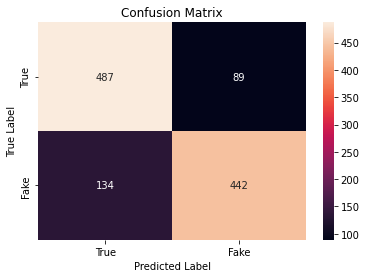

In [18]:
cm = confusion_matrix(y_valid, y_pred)
class_label = ["True", "Fake"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

не очень хорошо: из 576 фейков модель определила 134 как правду, а из 576 правдивых - 89 как фейк. 
 20 пройцентов определено неверно.

### 6.2 Оценка важности признаков <a class="anchor" id="feature_importances"></a>

In [19]:
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'features': X_train_df.columns,
                                       'feature_importances': feature_importances })

feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)

<AxesSubplot:xlabel='feature_importances', ylabel='features'>

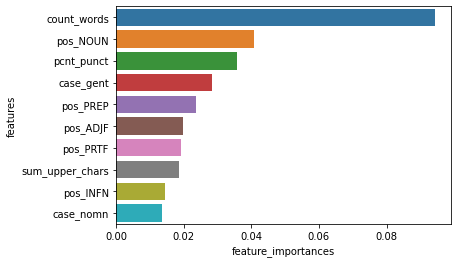

In [20]:
import seaborn as sns
sns.barplot(x=feature_importances_df['feature_importances'].head(10),y=feature_importances_df['features'].head(10))

Очень большое влияние имеет признак "количество слов", не думаю что это хорошо - и это особенность тренировочного набора данных, на которых модель получается переобучилась.

### 6.3 Логистическая регрессия <a class="anchor" id="log_reg"></a>

Для логистической регресии признаки стандартизирую , потому что алгоритм штрафует за большие значения весов.

скалировать буду только не векторизованные фитчи

In [21]:
scaler = StandardScaler().fit(X_train.drop(['is_fake','title','clean_text'],axis=1))
X_scaled_train = scaler.transform(X_train.drop(['is_fake','title','clean_text'],axis=1))
X_scaled_valid = scaler.transform(X_valid.drop(['is_fake','title','clean_text'],axis=1))

In [22]:
vect_train = vect_fit.transform(X_train['clean_text'])
vect_valid = vect_fit.transform(X_valid['clean_text'])

In [23]:
# добавлю новые признаки к стндартизованным выборкам 

X_scaled_train_df = pd.concat([pd.DataFrame(X_scaled_train),
                               pd.DataFrame(vect_train.toarray())], 
                        axis=1)

X_scaled_valid_df = pd.concat([pd.DataFrame(X_scaled_valid),
                               pd.DataFrame(vect_valid.toarray())], 
                        axis=1)

In [24]:
# создаем обучаем модель
model_lr = LogisticRegression()
model_lr.fit(X_scaled_train_df, y_train)

y_pred = model_lr.predict(X_scaled_valid_df)

precision, recall, fscore, support = score(y_valid, y_pred,  average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

Precision: 0.873 / Recall: 0.837 / F1-Score: 0.855


LogisticRegression: ROC AUC=0.926


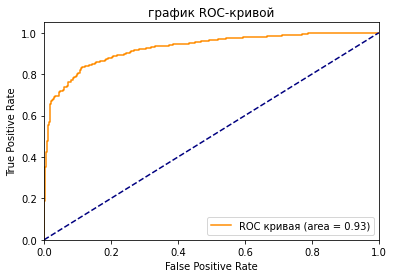

In [25]:

# получаем предказания
lr_probs = model_lr.predict_proba(X_scaled_valid_df)

# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_valid, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_valid, lr_probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('график ROC-кривой')
plt.legend(loc="lower right")
plt.show()


ROC AUC выглядит как у хоршей модели классификации

Сравню с классификатором "на дурочка".

In [26]:
model_dummy = DummyClassifier(strategy='stratified')
model_dummy.fit(X_train_df, y_train)
y_pred = model_dummy.predict(X_valid_df)

precision, recall, fscore, train_support = score(y_valid, y_pred,  average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)} ')

Precision: 0.513 / Recall: 0.509 / F1-Score: 0.511 


Проверка на адекватньсть модели прошли.

## 7. Финальное тестирование <a class="anchor" id="final"></a>

определился с моделью.
подгоовлю тетовый датафрейм - очистка текста, создание признаков, стандартизация

### 7.1 Подготовка тестового датасета   <a class="anchor" id="test_data"></a>



In [27]:
test_df['clean_text'] = test_df['title'].apply(lambda x: text_cleaning(x))

# доля знаков пунктуации в title
test_df['pcnt_punct'] = test_df['title'].apply(lambda x: pcnt_punct(x))

# количество слов в title
test_df['count_words'] = test_df['title'].apply(lambda x: sum([1 for y in x.split()]))

# количество заглавных букв 
test_df['sum_upper_chars'] = test_df['title'].apply(lambda x: sum([1 for y in x if y.isupper()]))

In [28]:
# создание признаков на каждую часть речи и падеж - перечень обозначений из библиотеки  pymorphy2
for pc in POS_case_list:
    if pc in POS_list:
        col_name = 'pos_' + pc
    else:
        col_name = 'case_' + pc
    test_df[col_name] = test_df['title'].apply(lambda x: get_pos_case_count(x,pc))

In [29]:
#test_df.head()

In [30]:
# векторизацию проведу обучив Tfidf на полном train_df

vect_fit = tfidfconverter.fit(train_df['clean_text'])
vect_train = vect_fit.transform(train_df['clean_text'])
vect_test = vect_fit.transform(test_df['clean_text'])


# стандартизация признаков
scaler = StandardScaler().fit(train_df.drop(['is_fake','title','clean_text'],axis=1))
X_scaled_train = scaler.transform(train_df.drop(['is_fake','title','clean_text'],axis=1))
X_scaled_test = scaler.transform(test_df.drop(['is_fake','title','clean_text'],axis=1))


# добавим новые признаки и удалим ненужные
X_train_df = pd.concat( [pd.DataFrame(X_scaled_train, columns=(train_df.drop(['is_fake','title','clean_text'],axis=1).columns)), 
                        pd.DataFrame(vect_train.toarray(), columns=vect_fit.get_feature_names())], 
                        axis=1)

X_test_df = pd.concat( [pd.DataFrame(X_scaled_test, columns=(train_df.drop(['is_fake','title','clean_text'],axis=1).columns)), 
                        pd.DataFrame(vect_test.toarray(), columns=vect_fit.get_feature_names())], 
                        axis=1)


    
X_test_df.head(5)

,pcnt_punct,count_words,sum_upper_chars,pos_NOUN,pos_ADJF,pos_ADJS,pos_COMP,pos_VERB,pos_INFN,pos_PRTF,...,являться,ядерный,язык,якутия,ян,январь,янукович,япония,японский,ёлка
0,0.974855,-0.257485,-0.541969,-0.029853,0.058289,-0.13297,-0.095463,0.019461,-0.495831,-0.313486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.436840,1.877285,2.246326,1.277332,1.162325,-0.13297,-0.095463,0.019461,-0.495831,-0.313486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.503498,0.809900,1.131008,1.930925,0.058289,-0.13297,-0.095463,0.019461,-0.495831,-0.313486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.436840,1.165695,-1.099629,-0.683446,2.266361,-0.13297,-0.095463,0.019461,-0.495831,2.933014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.503498,-0.257485,0.573349,-0.683446,-1.045747,-0.13297,-0.095463,0.019461,-0.495831,-0.313486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print(X_train_df.shape, X_test_df.shape)

(5758, 1530) (1000, 1530)


### 7.2 Тестирование <a class="anchor" id="test"></a>

In [32]:
model_lr_fin = LogisticRegression()
model_lr_fin.fit(X_train_df,train_df['is_fake'])
target_pred = model_lr.predict(X_test_df)

In [33]:
print(f'всего: {len(target_pred)}, из них предположительно фейков: {sum(target_pred)}')

всего: 1000, из них предположительно фейков: 475


In [34]:
test_df['is_fake'] = target_pred
test_df[['title','is_fake']].to_csv('dataset/predictions.tsv', sep="\t", index=False)

Идея о том что стиль написания заголовка помогает распознать фейковый(кликбейтный) текст требует более глубокого исследования.

Но очевидно что использование алгоритмов которые оценивают встречаемость лексических значений слов в одном предложении даст возможно лучший результат.